Przy wykorzystaniu zbioru danych z 41 atrybutami, celem projektu jest zbudowanie modelu predykcji, który określi poziom dochodu dla osób mieszkających w USA w latach 1995-1995. Poziomy dochodów podane w zbiorze dzielą się na: przychód niższy niż 50 000 USD i wyższy niż 50 000 USD rocznie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('tmp.csv')

In [3]:
def replace_nans(df):
    df = df.replace(' Not in universe', np.nan)
    df = df.replace(' ?', np.nan)
    df = df.replace(' Not in universe or children', np.nan)
    return df

In [4]:
def map_categories(df):
    education_mapping = {" Children": 0,
                     " Less than 1st grade": 1,
                     " 1st 2nd 3rd or 4th grade": 2,
                     " 5th or 6th grade": 3,
                     " High school graduate": 4,
                     " 7th and 8th grade": 5,
                     " 9th grade": 6,
                     " 10th grade": 7,
                     " 11th grade": 8,
                     " 12th grade no diploma": 9,
                     " Some college but no degree": 10,
                     " Bachelors degree(BA AB BS)": 11,
                     " Masters degree(MA MS MEng MEd MSW MBA)": 12,
                     " Associates degree-occup /vocational": 13,
                     " Associates degree-academic program": 14,
                     " Doctorate degree(PhD EdD)": 15,
                     " Prof school degree (MD DDS DVM LLB JD)": 16}

    df = df.replace(education_mapping)
    df['education'] = df['education'].astype('category')
    
    # salary mapping
    salary_mapping = {' - 50000.': 0,
                     ' 50000+.': 1}
    df = df.replace(salary_mapping)
    
    # maritial status mapping
    maritial_mapping = {'divorced': [' Divorced'],
                       'single': [' Never married', ' Widowed'],
                       'married': [' Married-A F spouse present', 
                                   ' Married-civilian spouse present',
                                  ' Married-spouse absent', ' Separated']}
    df = df.replace('divocred', 'divorced')
    df = df.replace([' Never married', ' Widowed'], 'single')
    df = df.replace(maritial_mapping['married'], 'married')
    
    # citizenship status mapping
    citizenship_mapping = {'native': [' Native- Born in the United States',
                                      ' Native- Born in Puerto Rico or U S Outlying',
                                      ' Native- Born abroad of American Parent(s)'],
                        'foreign': [' Foreign born- Not a citizen of U S ',
                                   ' Foreign born- U S citizen by naturalization'],
                       }
    df = df.replace(citizenship_mapping['native'], 'native')
    df = df.replace(citizenship_mapping['foreign'], 'foreign')
    return df

In [5]:
def outlier_region(cols):
    fig, axs = plt.subplots(2, 1, figsize=(22, 12), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i, column in enumerate(cols):
        isolation_forest = IsolationForest()
        isolation_forest.fit(df[column].values.reshape(-1,1))

        xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
        anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)

        axs[i].plot(xx, anomaly_score, label='anomaly score')
        axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                         where=outlier==-1, color='r', 
                         alpha=.4, label='outlier region')
        axs[i].legend()
        axs[i].set_title(column)

In [6]:
def biv_outlier(data_set, attribute1, attribute2, p, k):
    x = data_set[attribute1]
    y = data_set[attribute2]
    xy = list(zip(x, y))

    scaler = StandardScaler()
    x_n = scaler.fit_transform(np.reshape(np.array(x), (-1, 1)))
    x_n = np.squeeze(np.reshape(x_n, (1, -1)))
    y_n = scaler.fit_transform(np.reshape(np.array(y), (-1, 1)))
    y_n = np.squeeze(np.reshape(y_n, (1, -1)))
    xy_n = list(zip(x_n, y_n))

    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(xy_n)
    neighbor_matrix = nbrs.kneighbors_graph(xy_n, mode='distance')

    max_neighbor_indices = list(enumerate(np.squeeze(neighbor_matrix.argmax(1).tolist())))
    max_neighbor_distance = [neighbor_matrix[i] for i in max_neighbor_indices]
    argsort_max_neighbor_distance = np.argsort(max_neighbor_distance)[-p:]

    max_neighbor_indices = np.array(max_neighbor_indices)[argsort_max_neighbor_distance]

    fig, ax = plt.subplots()
    ax.scatter(x, y, label= attribute1 + " od " + attribute2)

    xy_outliers = np.array(xy)[max_neighbor_indices[:, 0]]
    ax.plot(xy_outliers[:, 0], xy_outliers[:, 1], 'ro', fillstyle='none', markersize=20, label="Elementy Odosobnione")
    ax.set_xlabel(attribute1)
    ax.set_ylabel(attribute2)
    ax.set_title('Outliers ' + attribute1 + ' oraz ' + attribute2)
    ax.legend()
    for o in xy_outliers:
        print(o)
    plt.show()

In [7]:
def transform_to_one_hot(df):
    def remove_col_append_dummies(dataset, col_name):
    # z danej kolumny robie dummies 
        prefix = 'col_' + str(col_name)
        dummies = pd.get_dummies(dataset[col_name], prefix=prefix)
        dataset = df.drop(col_name, axis=1)
        dataset = pd.concat([dataset, dummies], axis=1)
        return dataset
    # zamiana w one hot
    cats_to_one_hot = ['class of worker', 'marital stat', 'major industry code', 
                       'major occupation code', 'race', 'reason for unemployment',
                      'full or part time employment stat', 'tax filer stat', 'sex']
    for c in cats_to_one_hot:
        df = remove_col_append_dummies(df, c)
    return df

In [8]:
def drop_redundand_columns(df):
    df = df.drop(['detailed industry recode', 'detailed occupation recode',
             'enroll in edu inst last wk', 'hispanic origin', 'instance weight',
             'live in this house 1 year ago', 'migration prev res in sunbelt',
             'year'], axis=1)
    return df

In [9]:
def normalize_col(dataset, col_name):
    return ((dataset[col_name]-dataset[col_name].min()) / 
                       (dataset[col_name].max() - dataset[col_name].min()))

In [10]:
def normalize_data(df):
    df['dividends from stocks'] = normalize_col(df, 'dividends from stocks')
    df['weeks worked in year'] = normalize_col(df, 'weeks worked in year')
    df['capital gains'] = normalize_col(df, 'capital gains')
    df['capital losses'] = normalize_col(df, 'capital losses')
    return df

Cały preprocessing, zamiana '?' na nany, usuwanie kolumn których nie używamy a są numeryczne, mapowanie kategorii, transformacja kategorii do one-hot oraz normalizacja danych.

In [11]:
def prepare_data(df):
    df = replace_nans(df)
    df = drop_redundand_columns(df)
    df = map_categories(df)
    df = transform_to_one_hot(df)
    df = normalize_data(df)
    return df

[89  1]
[18  1]
[17  1]
[16  1]


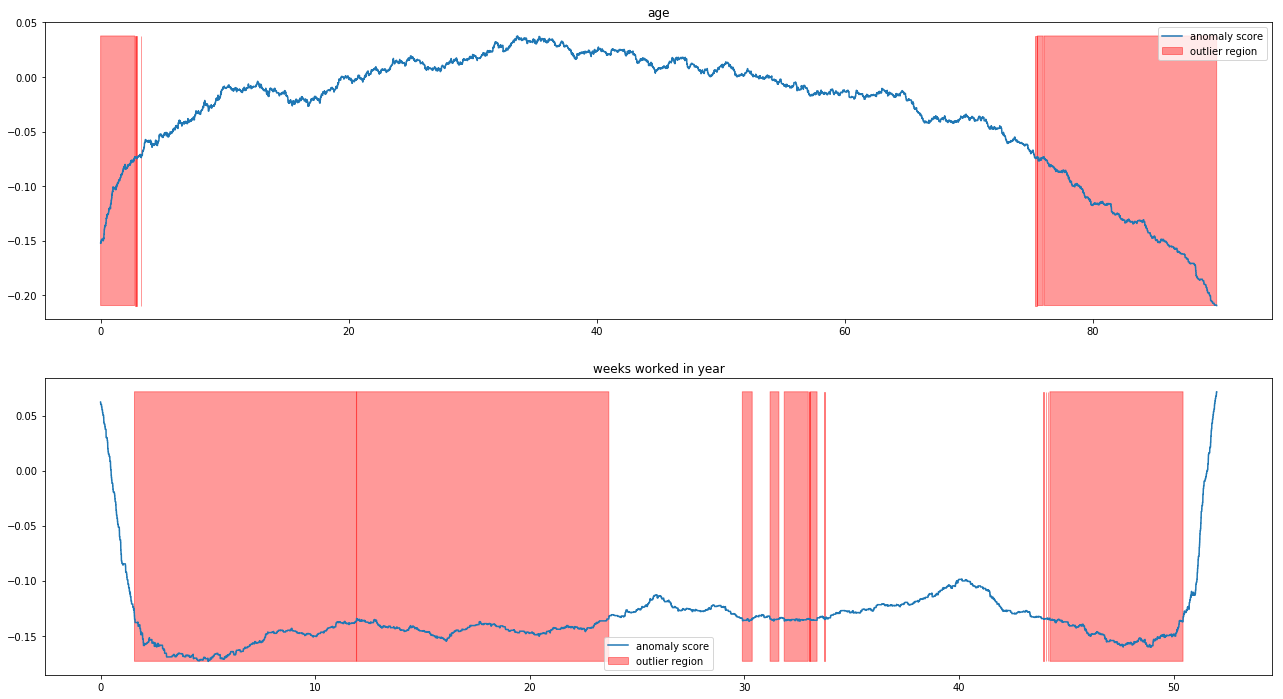

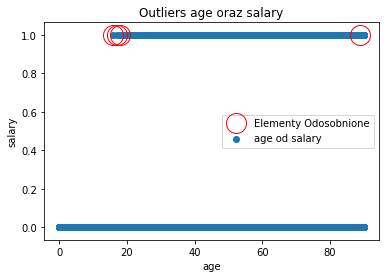

[23 16]
[20 12]
[17 11]
[15 11]


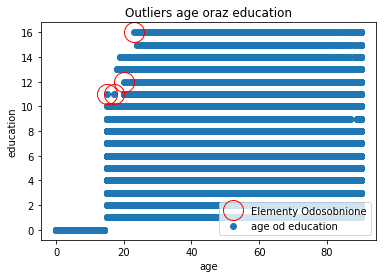

,age,education,wage per hour,member of a labor union,capital gains,capital losses,dividends from stocks,region of previous residence,state of previous residence,detailed household and family stat,...,col_full or part time employment stat_ Unemployed full-time,col_full or part time employment stat_ Unemployed part- time,col_tax filer stat_ Head of household,col_tax filer stat_ Joint both 65+,col_tax filer stat_ Joint both under 65,col_tax filer stat_ Joint one under 65 & one 65+,col_tax filer stat_ Nonfiler,col_tax filer stat_ Single,col_sex_ Female,col_sex_ Male
0,73,4,0,NaN,0.0,0.0,0.0,NaN,NaN,Other Rel 18+ ever marr not in subfamily,...,0,0,0,0,0,0,1,0,1,0
1,58,10,0,NaN,0.0,0.0,0.0,South,Arkansas,Householder,...,0,0,1,0,0,0,0,0,0,1
2,18,7,0,NaN,0.0,0.0,0.0,NaN,NaN,Child 18+ never marr Not in a subfamily,...,0,0,0,0,0,0,1,0,1,0
3,9,0,0,NaN,0.0,0.0,0.0,NaN,NaN,Child <18 never marr not in subfamily,...,0,0,0,0,0,0,1,0,1,0
4,10,0,0,NaN,0.0,0.0,0.0,NaN,NaN,Child <18 never marr not in subfamily,...,0,0,0,0,0,0,1,0,1,0


In [12]:
df = replace_nans(df)
df = drop_redundand_columns(df)
df = map_categories(df)
outlier_region(['age','weeks worked in year'])
biv_outlier(df, 'age', 'salary', 4, 3)
biv_outlier(df, 'age', 'education', 4, 3)
df = transform_to_one_hot(df)
df = normalize_data(df)
df.head()

In [13]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.columns, len(numerical_features.columns)

(Index(['age', 'education', 'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks', 'num persons worked for employer',
        'own business or self employed', 'veterans benefits',
        'weeks worked in year', 'salary',
        'col_class of worker_ Federal government',
        'col_class of worker_ Local government',
        'col_class of worker_ Never worked', 'col_class of worker_ Private',
        'col_class of worker_ Self-employed-incorporated',
        'col_class of worker_ Self-employed-not incorporated',
        'col_class of worker_ State government',
        'col_class of worker_ Without pay', 'col_marital stat_ Divorced',
        'col_marital stat_married', 'col_marital stat_single',
        'col_major industry code_ Agriculture',
        'col_major industry code_ Armed Forces',
        'col_major industry code_ Business and repair services',
        'col_major industry code_ Communications',
        'col_major industry code_ Construction',
 

Tutaj widzę które dane nie są zawarte. Widać, że enroll in edu inst last wk można zupełnie pominąć. Co do innych należy się zastanowić.

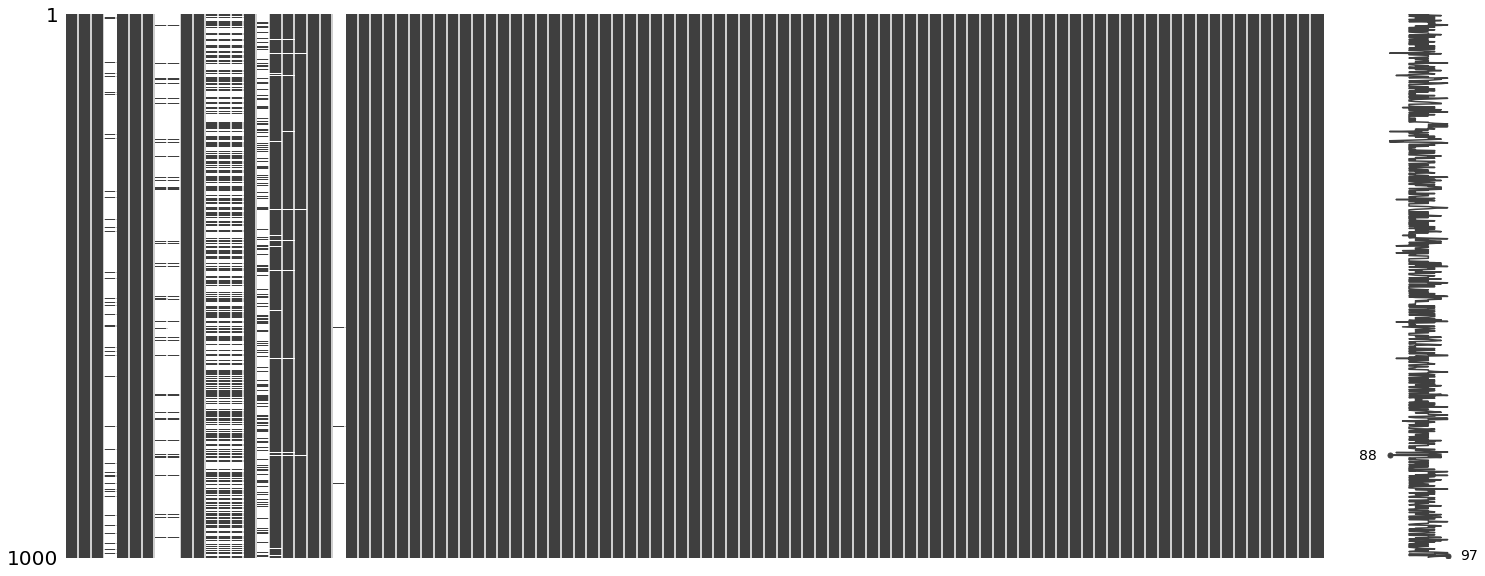

In [14]:
msno.matrix(df.sample(1000))

Tutaj widzę które brakujące wartości są ze sobą powiązane. Tzn. jeśli nie ma "major industry code" to nie ma również "major occupation code". Co ciekawe istnieje ujemna korelacja dla "famili member under 18". Trzeba to zbadać.

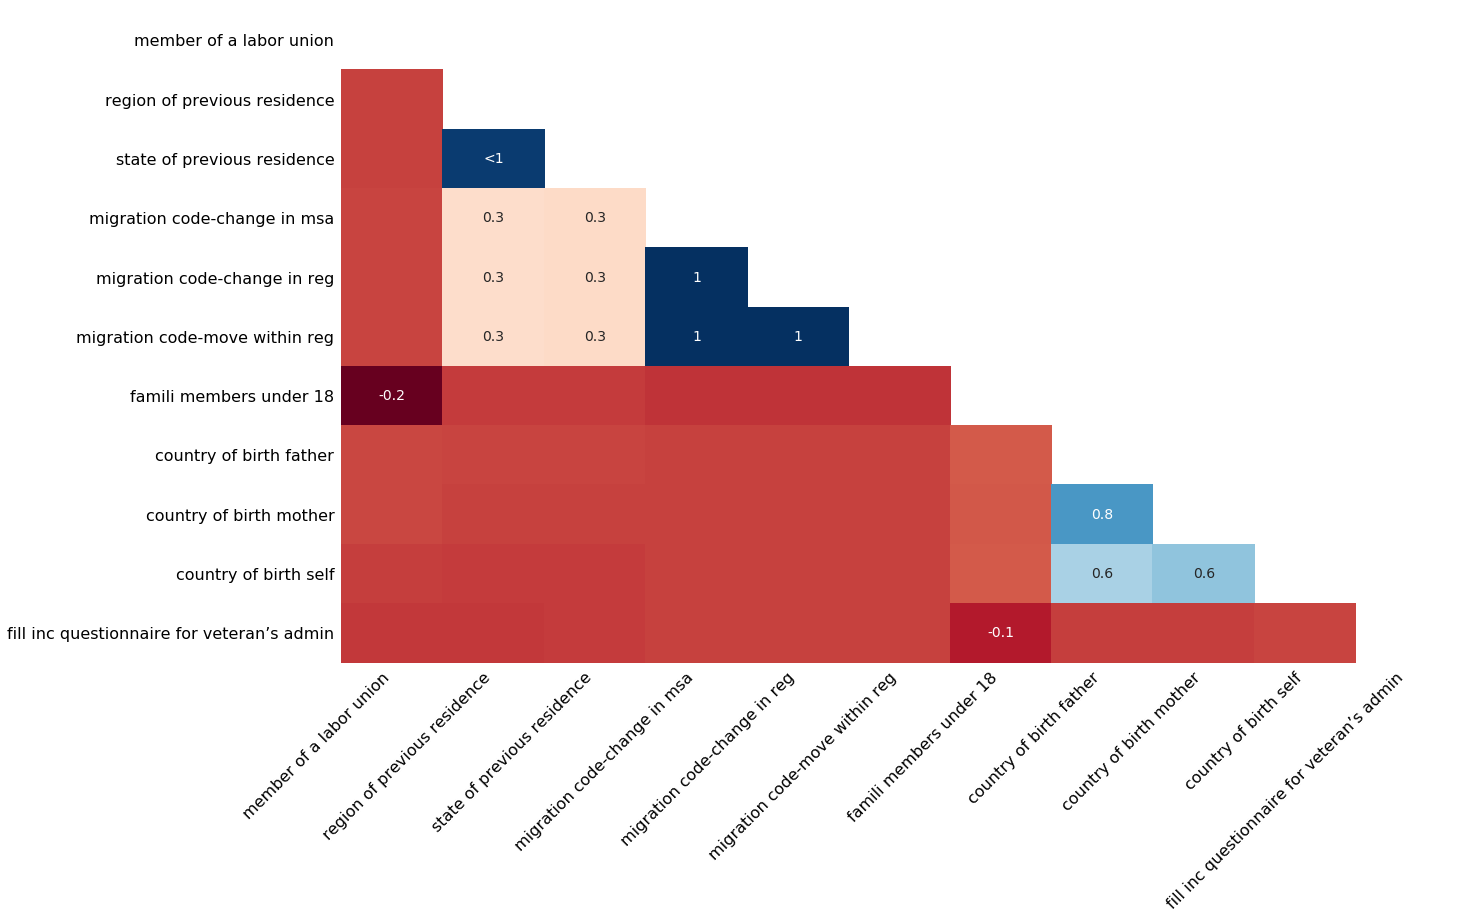

In [15]:
msno.heatmap(df)

Ile pustych rekordów dla kategorycznych rekordów:

In [16]:
cat_df = df.select_dtypes(include=['object', 'category']).copy()
cat_df.isnull().sum()

member of a labor union                       180459
region of previous residence                  183750
state of previous residence                   184458
detailed household and family stat                 0
detailed household summary in household            0
migration code-change in msa                  101212
migration code-change in reg                  101212
migration code-move within reg                101212
famili members under 18                       144232
country of birth father                         6713
country of birth mother                         6119
country of birth self                           3393
citizenship                                        0
fill inc questionnaire for veteran’s admin    197539
dtype: int64

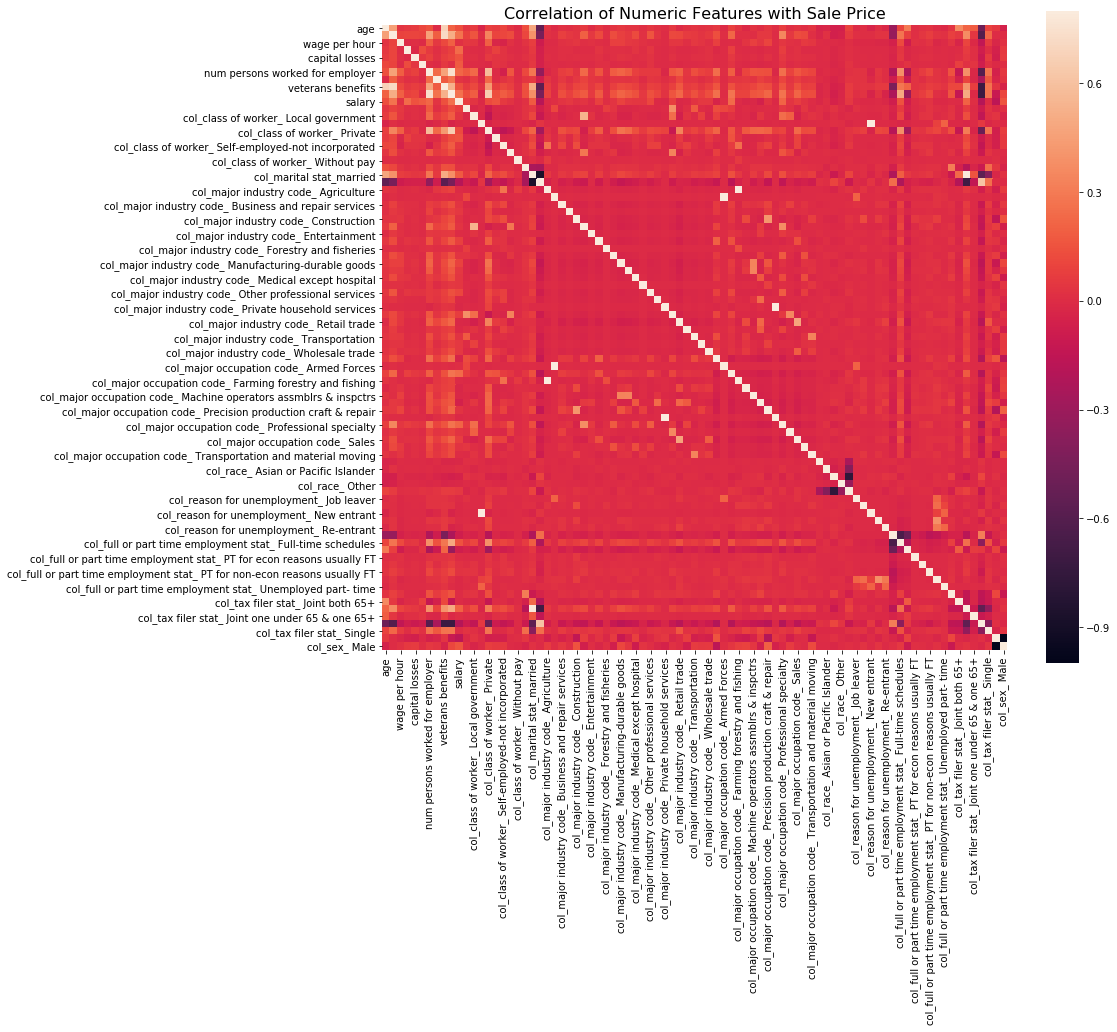

In [17]:
correlation = numerical_features.corr()
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [18]:
data_corr=df.corr(method='pearson')
data_corr.sort_values('salary').salary

col_tax filer stat_ Nonfiler                                       -0.198326
col_marital stat_single                                            -0.189925
col_sex_ Female                                                    -0.157610
col_full or part time employment stat_ Children or Armed Forces    -0.077344
col_full or part time employment stat_ Not in labor force          -0.073197
col_major occupation code_ Other service                           -0.054909
col_race_ Black                                                    -0.049827
col_major occupation code_ Adm support including clerical          -0.037592
col_major occupation code_ Handlers equip cleaners etc             -0.025852
col_reason for unemployment_ Re-entrant                            -0.021233
col_race_ Other                                                    -0.021054
col_major industry code_ Retail trade                              -0.020078
col_major occupation code_ Machine operators assmblrs & inspctrs   -0.018996

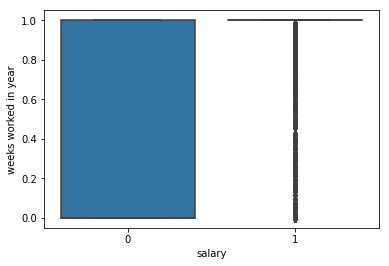

In [ ]:
sns.boxplot(x=df['salary'], y=df['weeks worked in year'])

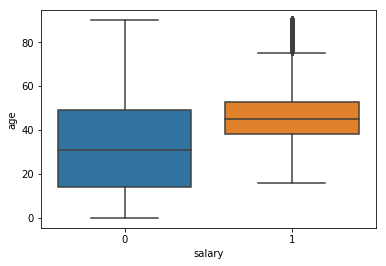

In [ ]:
sns.boxplot(x=df['salary'], y=df['age'])

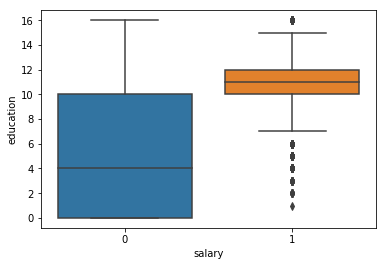

In [ ]:
sns.boxplot(x=df['salary'], y=df['education'])

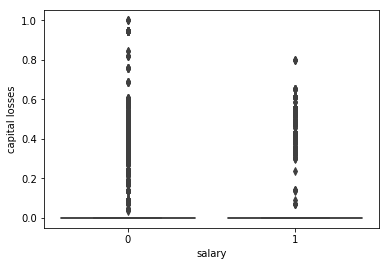

In [ ]:
sns.boxplot(x=df['salary'], y=df['capital losses'])

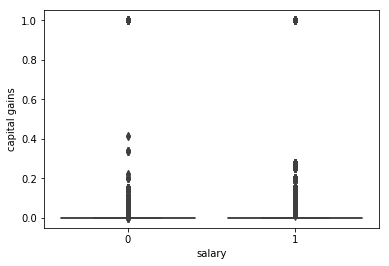

In [ ]:
sns.boxplot(x=df['salary'], y=df['capital gains'])

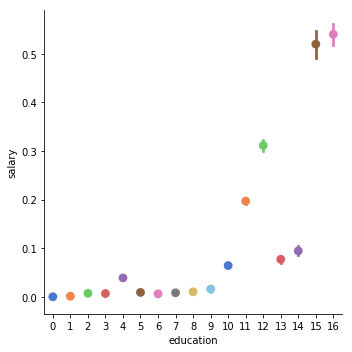

In [ ]:
g = sns.factorplot(x="education",y="salary",data=df,palette = "muted")

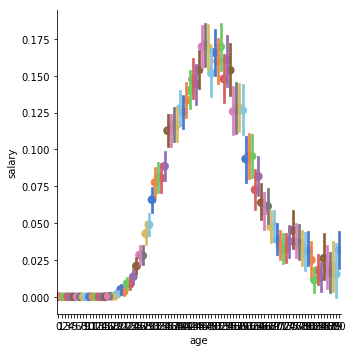

In [ ]:
g = sns.factorplot(x="age",y="salary",data=df,palette = "muted")

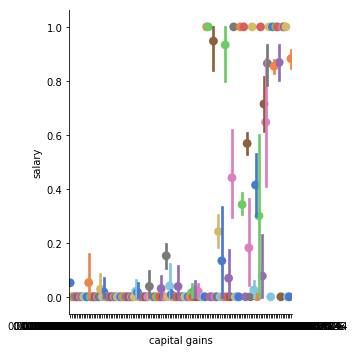

In [ ]:
g = sns.factorplot(x="capital gains", y='salary',data=df,palette = "muted")

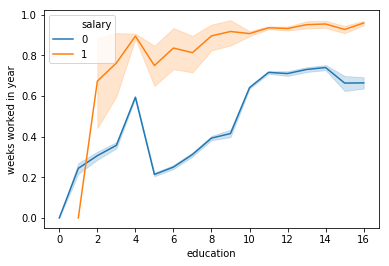

In [ ]:
sns.lineplot(x='education', y='weeks worked in year', hue='salary', data=df)

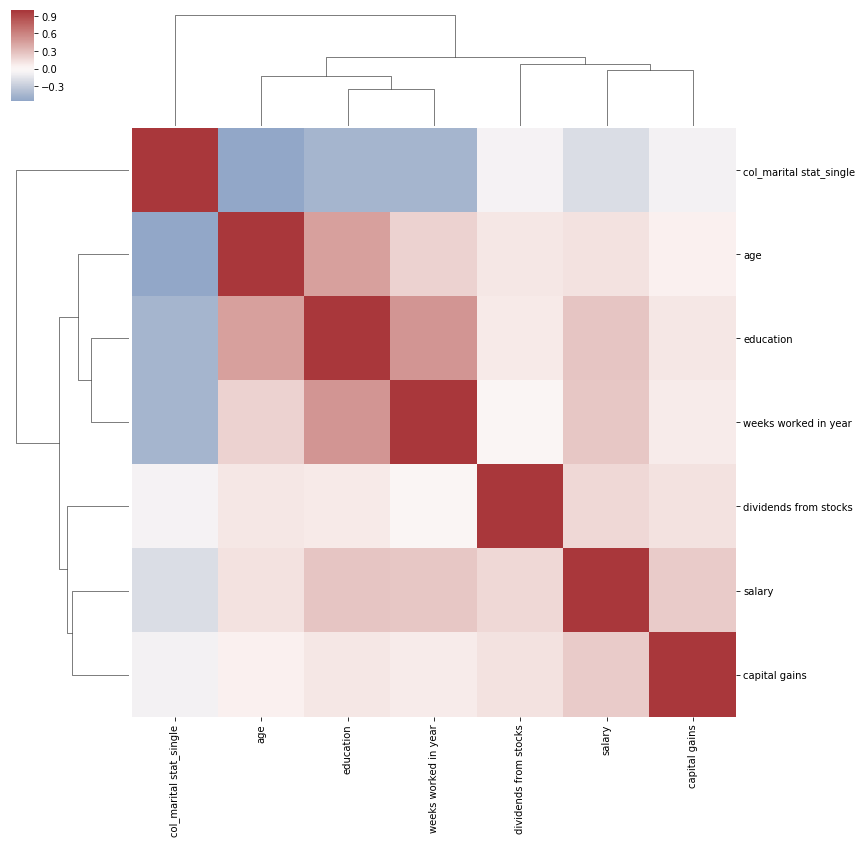

In [ ]:
after_reduction = df.filter(['salary', 'education', 'weeks worked in year',
                            'capital gains', 'dividends from stocks', 'col_sex_1',
                            'age', 'col_sex_0', 'col_marital stat_single'])
sns.clustermap(after_reduction.corr(), center=0, cmap="vlag", figsize=(13,13))

Klasteryzacja
TODO. Podać średnie wartości które mają rekordy należące do tych klastrów.

In [ ]:
def cluster(dataset, clusters_num):
    numerical_features = dataset.select_dtypes(include=[np.number])

    pca = PCA(n_components=2).fit(numerical_features)
    pca_2d = pca.transform(numerical_features)
    pca_2d_x = [p[0] for p in pca_2d]
    pca_2d_y = [p[1] for p in pca_2d]
    
    kmeans = KMeans(n_clusters=clusters_num).fit(numerical_features)
    
    clusters_centers = pca.transform(kmeans.cluster_centers_)
    clusters_centers_x = [p[0] for p in clusters_centers]
    clusters_centers_y = [p[1] for p in clusters_centers]
    
    labels = kmeans.labels_
    plt.figure(figsize=(15,15))
    plt.scatter(pca_2d_x, pca_2d_y,c=labels)
    plt.scatter(clusters_centers_x, clusters_centers_y, c='red')

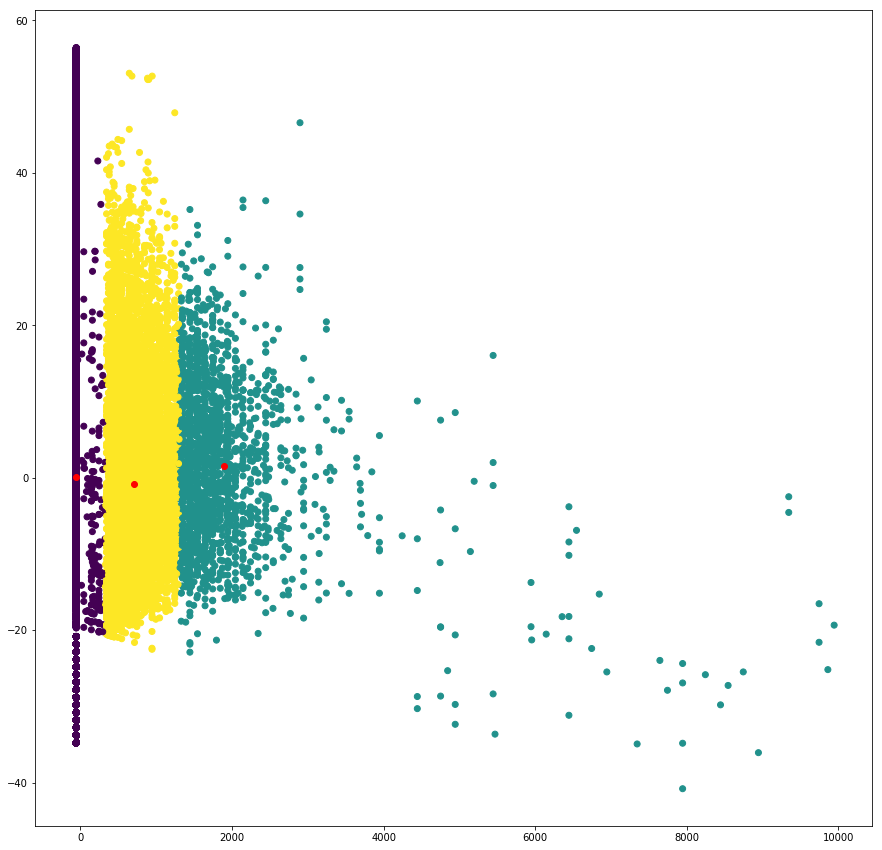

In [ ]:
cluster(df, 3)

In [ ]:
cluster(df, 5)

In [ ]:
cluster(df, 10)

Klasyfikacja z użyciem random forest.

In [ ]:
df_test = pd.read_csv('tmp_test.csv')
df = pd.read_csv('tmp.csv')

In [ ]:
df_test = prepare_data(df_test)
df = prepare_data(df)

In [ ]:
df_test['target'] = df_test['salary']
df_test = df_test.drop(['salary'], axis=1)

df['target'] = df['salary']
df = df.drop(['salary'], axis=1)
df.head()

In [ ]:
df = df.select_dtypes(include=[np.number])

Y_train = df.target
X_train = df.drop(['target'], axis=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

Które cechy najbardziej wpływają na pensję.

In [ ]:
features_importance = list()
for i, v in enumerate(clf.feature_importances_):
    features_importance.append((i, v))
features_importance.sort(key=lambda x: x[1], reverse=True)
for f in features_importance:
    print("{} : {}".format(df.columns[f[0]], f[1]))

In [ ]:
df_test = df_test.select_dtypes(include=[np.number])
Y_test = df_test.target
X_test = df_test.drop(['target'], axis=1)
predictions = clf.predict(X_test)
df_test.columns
